# Target: IC 5146 (Cocoon nebula)

![Image not found](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/IC5146_The_Cocoon_Nebula.jpg/1200px-IC5146_The_Cocoon_Nebula.jpg)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Latex

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

## Properties of the target

In [2]:
# Right Ascension = 21h 54m 26s
# Declination =    +47° 23’ 04”

Radius = 5*60       # in arcsec (we approximate the nebula to be circular)
Magnitude_V = 7.2   # V band (551nm)
lambda_V = 5510     # in Angstrom

## Properties of the detector

In [3]:
# 4499 X 3599 square pixels, with a side of 6 microns
L_pixel_arcsec = 0.44    # in arcsec
L_pixel_cm = 6e-4        # in cm

Area_pixel_arcsec = L_pixel_arcsec**2
Area_pixel_cm2 = L_pixel_cm**2

Saturation_pixel = 40000 # in electrons per pixel

RON = 9                  # Readout Noise, in electrons per pixel

DarkCurrent = 0.25       # Dark current noise, in electrons per second per pixel at 0 °C
# We are interested in the dark current at T_operational = -20 °C
# We conservatively assume that the dark current doubles every 10 °C
DarkCurrent = DarkCurrent/4

In [4]:
Area_target = np.pi*Radius**2
NPixels_target = int(Area_target/L_pixel_arcsec**2)
Target_fraction = NPixels_target/(4499*3599)
print("Number of pixels covered by the target: ", NPixels_target)
print("Total number of pixels: ", 4499*3599)
print(f"Percentage of pixels covered by the target: {Target_fraction*100:.1f} %")

Number of pixels covered by the target:  1460451
Total number of pixels:  16191901
Percentage of pixels covered by the target: 9.0 %


## From magnitude to flux

Reference: [AB magnitude system](https://en.wikipedia.org/wiki/AB_magnitude)

We have a value for the magnitude and we want a flux.

$m = -2.5 \log_{10} \left(f_\nu / f_0\right)$ 

Let us consider the *AB magnitude* system, in which $f_0 = f_\text{Vega, V band} \approx 3631 \text{ Jy} = 3631 \times 10^{-23} erg/s/cm^2/Hz$. \
We can also extract this value from the logarithm, obtaining:

$m_{AB} = -2.5 \log_{10} \left(f_\nu\right) - 48.60$ 

The resulting flux is given by:

$f_\nu \left[erg/s/cm^2/Hz\right] = 10^{-0.4\left(m_{AB} + 48.60\right)}$

In [5]:
f_nu = 10**(-0.4*(Magnitude_V + 48.60)) 
display(Latex(f'$f_\\nu = {f_nu:.2e} \:\:\: erg/s/cm^2/Hz$'))

<IPython.core.display.Latex object>

We still have to convert from $f_\nu \left[erg/s/cm^2/Hz\right]$ to $f_\lambda \left[erg/s/cm^2/\AA\right]$. \
We can take advantage of $f_\lambda d\lambda = f_\nu d\nu$:

$f_\lambda = f_\nu \left\vert\dfrac{d\nu}{d\lambda}\right\vert \overset{\lambda \nu = c}{=} f_\nu \left\vert\dfrac{d\left(c/\lambda\right)}{d\lambda}\right\vert = f_\nu \dfrac{c}{\lambda^2}$

In general, we should compute an integral, as our flux corresponds to a band of wavelengths.\
For simplicity, we consider the mean wavelength.

In [6]:
c_light = 2.99792458*10**18   # in Angstrom/s

f_lambda = f_nu * c_light / lambda_V**2
display(Latex(f'$f_\\lambda = {f_lambda:.2e} \:\:\: erg/s/cm^2/\AA$'))

<IPython.core.display.Latex object>

In [7]:
# This is not necessary, but in principle we can calculate the number of photons per second per cm2

# We shift from the V band to the G band, as the latter is the one used to estimate the rate of photoelectrons
lambda_G = 4770     # in Angstrom
FWHM_G = 1500       # in Angstrom

# We assume that all photons in the band have the same energy, corresponding to the mean wavelength, even though this is not true
h_plank = 6.62607015*10**(-27) # in erg*s
photon_energy = h_plank * c_light / lambda_G

# f_lambda/photon_energy gives the number of photons per second per cm2 per unit wavelength.
# To obtain the number of photons per second per cm2, we need to multiply f_lambda/photon_energy by the bandwidth of the V band (or at least I think so)
f_photons = (f_lambda / photon_energy) * FWHM_G
display(Latex(f'$f_\\text{{photons}} = {f_photons:.2f} \:\:\: \\text{{photons}}/s/cm^2$'))

display(Latex(f'$f_\\text{{photons}} = {f_photons*Area_pixel_cm2:.5f} \:\:\: \\text{{photons}}/s/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<font color='red'>This is totally incompatible with the number of electrons per second in the calibration table (the detector has an area of 6 cm2).\
The number of photons should be greater than that of photoelectrons, not the other way around...</font>

## Calibration

Not all the photons that enter in our telescope will end up producing a photoelectron due to a handful of reasons: dust on the mirrors, transmittance of the filters, and quantum efficiency of the detector.\
The calibration constant C is the conversion factor between counts in $\left[e^-/s\right]$ and specific fluxes in $\left[erg/s/cm^2/\AA\right]$.

$N_e \left[e^-/s\right] = 10^C f_\lambda \left[erg/s/cm^2/\AA\right]$

<font color='red'>Does this formula assume a uniform flux over the full area of the detector?\
Should we adjust for the fact that our target covers only 9% of the detector (I did it)?</font>

In the g filter, we have $C = 17.61 \pm 0.04$. Actually, this is not the V band for which we have the magnitude, but it is the closest available.

In [8]:
C_calibration = 17.61

Ne = (10**C_calibration * f_lambda)*Target_fraction
display(Latex(f'$N_\\text{{electrons}} = {Ne:.0f} \:\:\: e/s$'))

Ne_pixel = Ne/NPixels_target
display(Latex(f'$N_\\text{{electrons, per pixel}} = {Ne_pixel:.3f} \:\:\: e/s/\\text{{pixel}}$'))

Saturation_time = Saturation_pixel / Ne_pixel
display(Latex(f'$\\text{{Pixels start saturating after an average time of }} \: {Saturation_time/60/60:.1f} \:\:\: \\text{{hours}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Estimate of the SNR

$\text{SNR} (\Delta t =1s) = \dfrac{N_\text{electrons}}{\sqrt{N_\text{e} + N_\text{triggered pixels}\left(N_\text{e, sky bkg} + N_\text{e, dc} + \text{RON}^2\right)}}$

In [9]:
display(Latex(f'$N_\\text{{electrons}} = {Ne:.0f} \:\:\: e/s$'))
display(Latex(f'$N_\\text{{triggered pixels}} = {NPixels_target:.0f} \:\:\: \\text{{pixels}}$'))
display(Latex(f'$N_\\text{{e, dc}} = {DarkCurrent:.3f} \:\:\: e/s/\\text{{pixel}}$'))
display(Latex(f'$\\text{{RON}} = {RON:.1f} \:\:\: e/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We still have to determine $N_\text{e, sky bkg}$.\
In the g filter, we have an estimated sky background of  $f_\text{bkg} = 10^{-17.47+/-0.02} \left[erg/s/cm^2/\AA\right/\text{arcsec}^2]$.\
If we multiply this number by the area of one pixel in arcseconds^2, we get the total flux of background photons per pixel

In [10]:
f_bkg = Area_pixel_arcsec * 10**(-17.47)
display(Latex(f'$f_\\text{{bkg}} = {f_bkg:.2e} \:\:\: erg/s/cm^2/\AA/\\text{{pixel}}$'))

Ne_bkg = 10**C_calibration * f_bkg
display(Latex(f'$N_\\text{{electrons, bkg}} = {Ne_bkg:.3f} \:\:\: e/s/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [11]:
# Same result as above, but I find this more convincing

#f_bkg_detector = (4499*3599)*Area_pixel_arcsec * 10**(-17.47)
#display(Latex(f'$f_\\text{{bkg, detector}} = {f_bkg_detector:.2e} \:\:\: erg/s/cm^2/\AA$'))
#
#Ne_bkg_target = (10**C_calibration * f_bkg_detector)*Target_fraction
#display(Latex(f'$N_\\text{{electrons, bkg, target}} = {Ne_bkg_target:.0f} \:\:\: e/s$'))
#
#Ne_bkg_pixel = Ne_bkg_target/NPixels_target
#display(Latex(f'$N_\\text{{electrons, bkg, pixel}} = {Ne_bkg_pixel:.3f} \:\:\: e/s/\\text{{pixel}}$'))

In [12]:
Noise = np.sqrt(Ne + NPixels_target*(Ne_bkg + DarkCurrent + RON**2))
SNR = Ne/Noise
display(Latex(f'$\\text{{SNR (t=1s)}} = {SNR:.2f}$'))

<IPython.core.display.Latex object>

## SNR as a function of the exposure time

$\text{SNR} (\Delta t) = \dfrac{N_\text{electrons} \times \Delta t}{\sqrt{N_\text{e} \times \Delta t + N_\text{triggered pixels}\left(N_\text{e, sky bkg} \times \Delta t + N_\text{e, dc} \times \Delta t + \text{RON}^2\right)}}$

In [13]:
def SNR_func(t, NPixels_target, Ne, Ne_bkg, DarkCurrent, RON):
    return Ne*t/np.sqrt(Ne*t + NPixels_target*(Ne_bkg*t + DarkCurrent*t + RON**2))

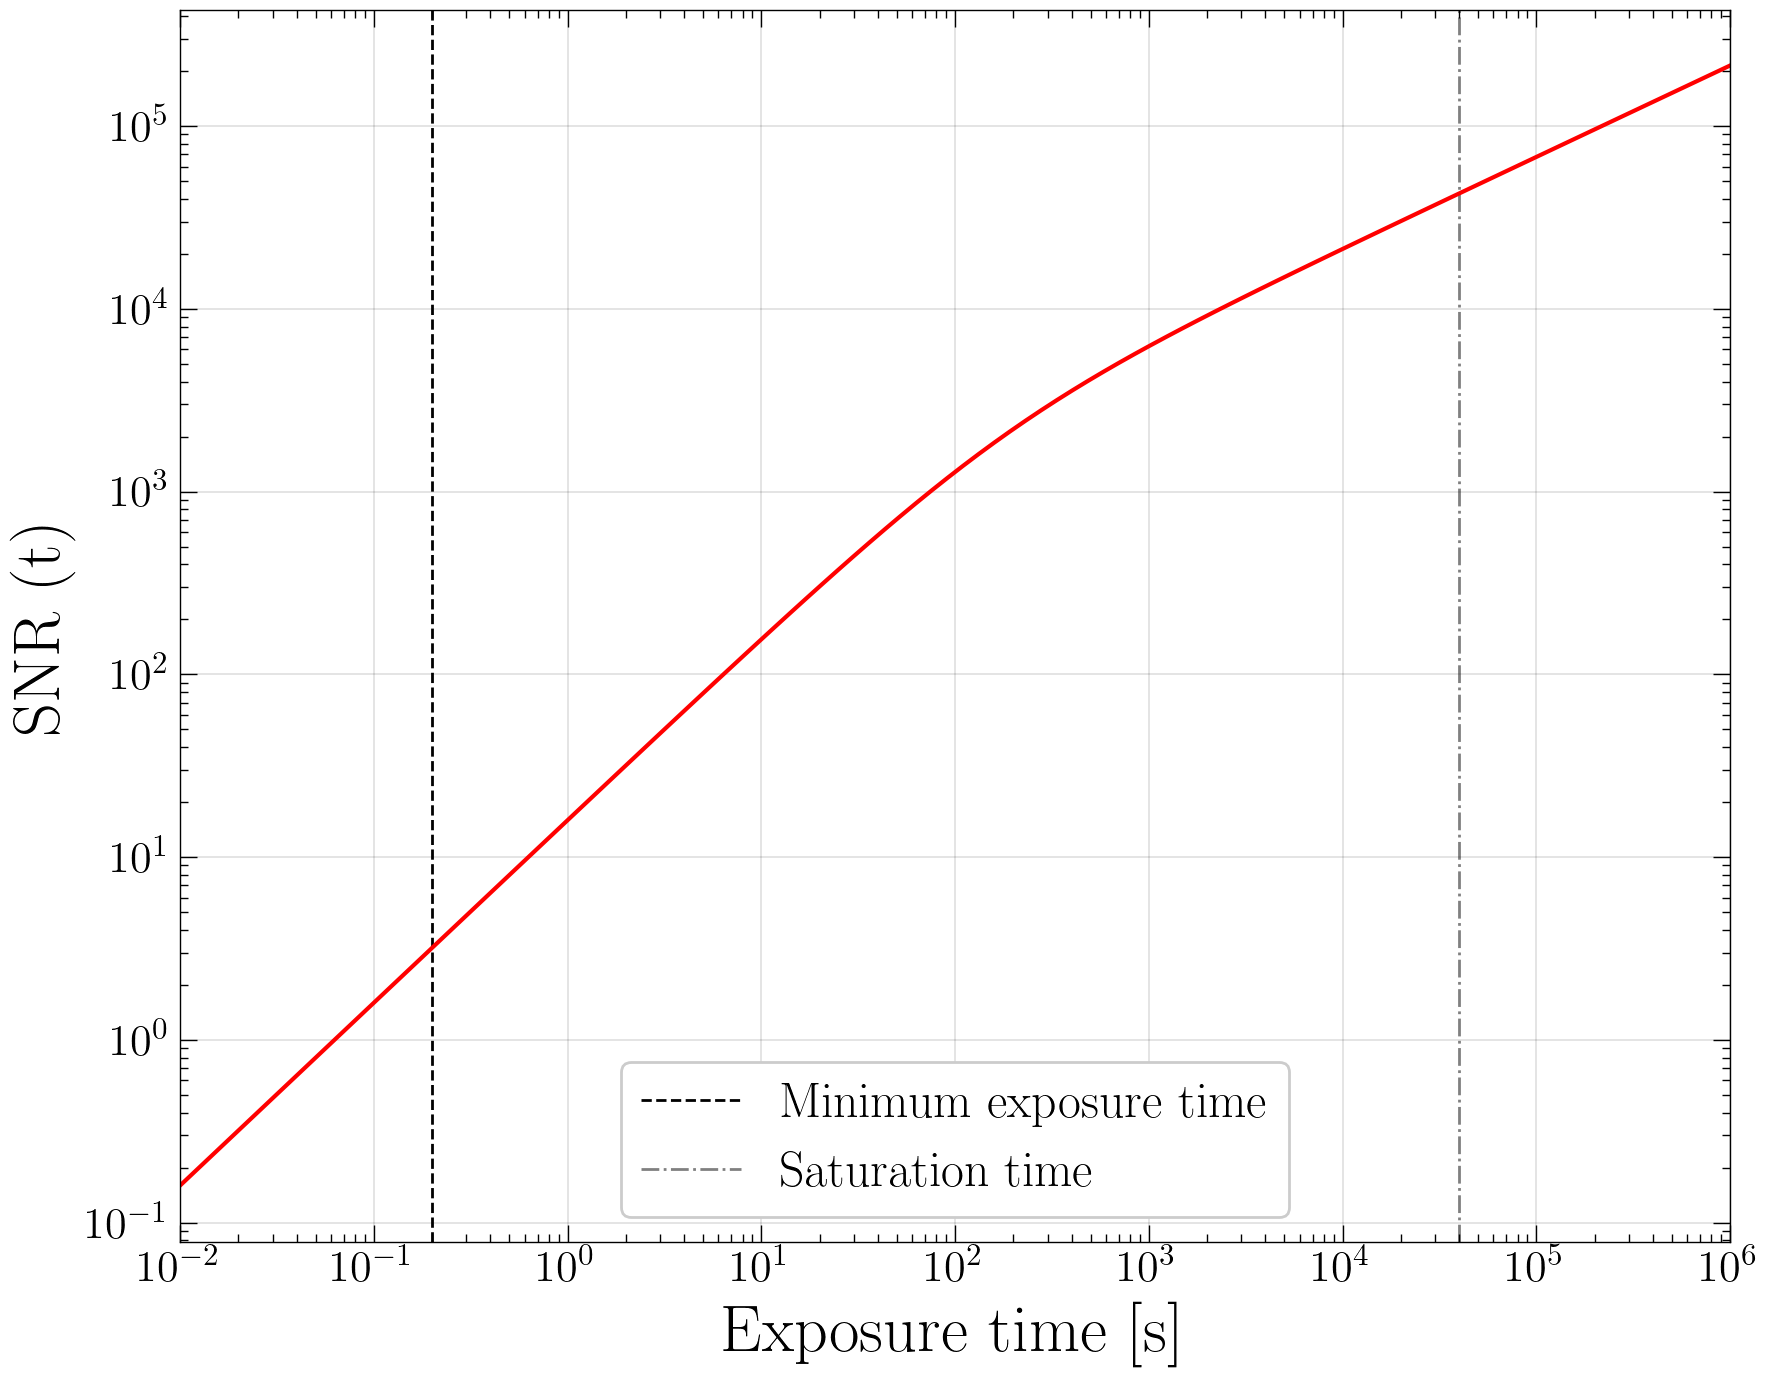

In [14]:
t_exposure = np.logspace(start=-2, stop=6, num=100) # in seconds
SNR_t_exposure = SNR_func(t_exposure, NPixels_target, Ne, Ne_bkg, DarkCurrent, RON)

plt.plot(t_exposure, SNR_t_exposure, color='red')
plt.axvline(0.2, color='black', linestyle='--', linewidth=1, label='Minimum exposure time', zorder=0)
plt.axvline(Saturation_pixel, color='gray', linestyle='-.', linewidth=1, label='Saturation time', zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, 1e6)
plt.xlabel('Exposure time [s]')
plt.ylabel('SNR (t)')
plt.legend();